# 캐글 경진대회 따라하기 - House Price Prediction(집값 예측)
![img](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

캐글코리아: [대회 링크](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)



이번프로젝트에서는 집값 예측 Baseline 모델을 기초로 하여 집값 예측 모델을 개선하는 시도를 해볼것이다.

지금까지 배운 모델의 성능을 최적화하기 위해 이번프로젝트에서 시도해볼수 있는 방법들을 정리해보았다.

- 피처 엔지니어링
 - EDA 과정을 통해 불필요한 피처를 삭제하거나 피처를 수정
 - 데이터에 대한 전처리, 왜곡이 심한경우 정규화처리

- 하이퍼 파라미터 튜닝
 - LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법

---

## 데이터 살펴보기

### File descriptions
- train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
- test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
- sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.

### Data fields

- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

# 라이브러리

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

# 데이터셋 설정

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/project/exp05_Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      

print(train_data_path)
print(test_data_path)

/aiffel/aiffel/project/exp05_Kaggle/data/train.csv
/aiffel/aiffel/project/exp05_Kaggle/data/test.csv


In [6]:
X_train = pd.read_csv(train_data_path)
X_test = pd.read_csv(test_data_path)
print('X_train data dim: {}'.format(X_train.shape))
print('X_test data dim: {}'.format(X_test.shape))

X_train data dim: (15035, 21)
X_test data dim: (6468, 20)


학습 데이터는 약 1만 5천 개, 테스트 데이터는 약 6천 개로 구성되어있다. 학습데이터셋에는 예측 레이블인 가격정보(price 컬럼)가 포함되어있다.

# EDA를 통해 데이터 보완하기

In [4]:
X_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


데이터 프레임 5행 만보았을때 대부분 숫자이거나 실수형 데이터로 모델학습에 적절해 보이지만 date컬럼은 수정이 필요해보인다. date컬럼의 데이터중 앞에 6자리 숫자부분남기고 숫자형으로 변경하였다.

In [7]:
X_train['date'] = X_train['date'].apply(lambda i:i[:6]).astype(int) # 수치형으로 변환
X_test['date'] = X_test['date'].apply(lambda i:i[:6]).astype(int)

### 결측치 확인

In [18]:
X_train.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [19]:
X_test.isna().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

훈련셋 테스트셋 모두 결측치가 없는 데이터로 확인된다.

# 타겟데이터 : price 의 분포 및 정규화

<AxesSubplot:xlabel='price', ylabel='Density'>

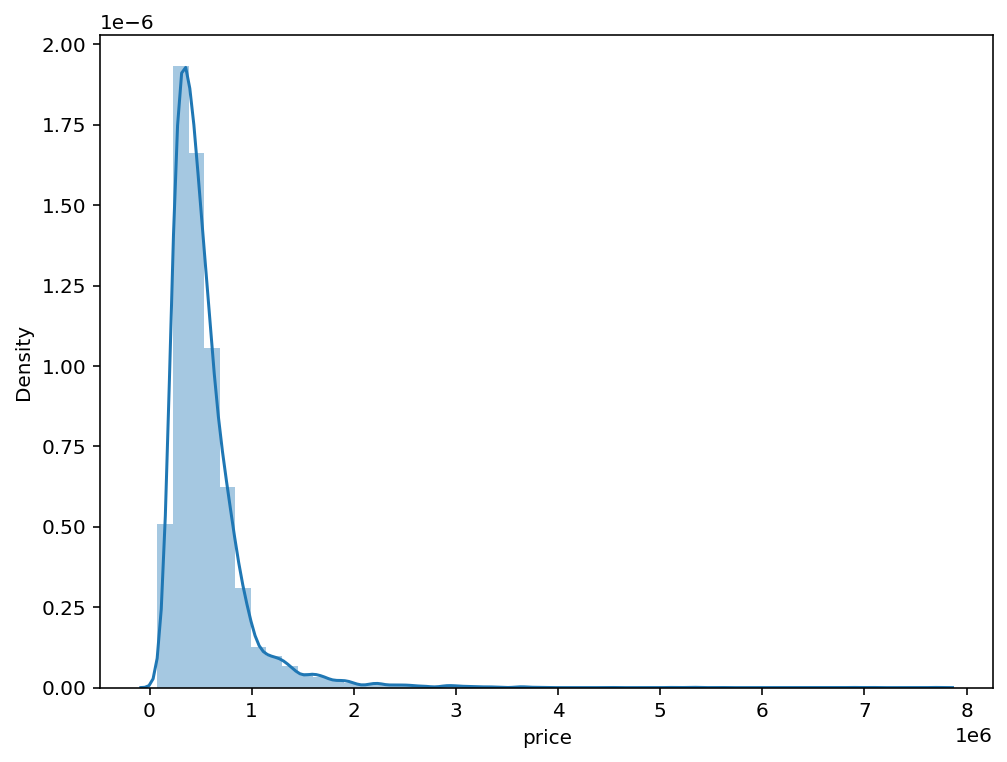

In [8]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(X_train['price'])

가격데이터가 한쪽으로 치우친 분포를 보였다. 회귀모델을 사용할 것이기 때문에 Normalize를 통해 price의 분포가 정규분포를 가지도록 만들어야한다. log를 취해주면 기존보다 더 정규성을 가지는 것을 확인할 수 있다고 한다.

<AxesSubplot:xlabel='price', ylabel='Density'>

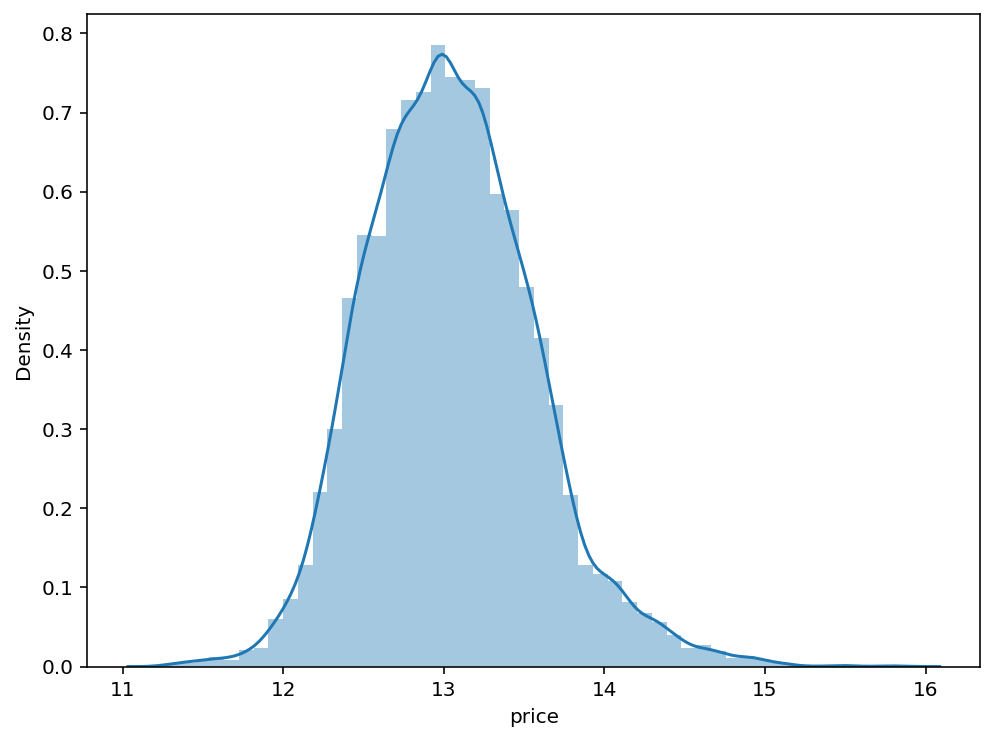

In [9]:
X_train['price'] = np.log1p(X_train['price'])

f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(X_train['price'])

---

이제 위에 타겟 데이터와 상관관계 높은 특징이 무엇이 있는지 히트맵을 통해 알아보겠다. 
 - 컬럼이 21개가 있으므로 correlation이 높은 상위 10개만 출력

### 상관계수란?
 - 두 개의 변수가 같이 일어나는 강도를 나타내는 수치 -1에서 1사이의 값을 지닌다.
 - 분야별로 기준을 정하는 것에 따라 달라지겠지만, 보통 0.4이상이면 두 개의 변수간에 상관성이 있다고 함


['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

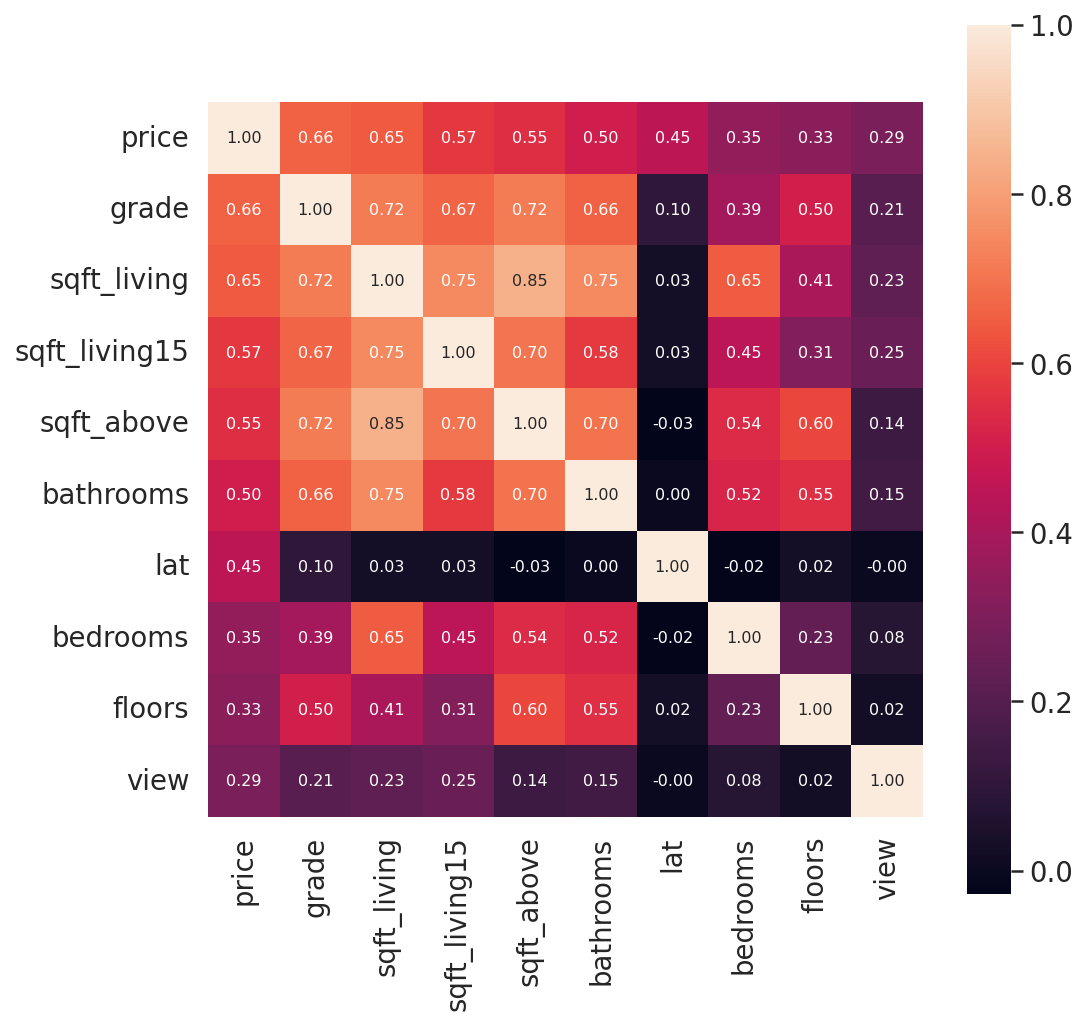

In [8]:
import scipy as sp

cor_abs = abs(X_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)

# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(X_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(8,8))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

grade, sqft_living , sqft_living15, sqft_above, bathrooms 컬럼이 가격에 영향을 미치는 주요 특성으로 보인다. 따라서 위 주요특성들 위주로 이상치가 있는지 살펴보고 피처엔지니어링을 진행하면될것 같다.

## grade

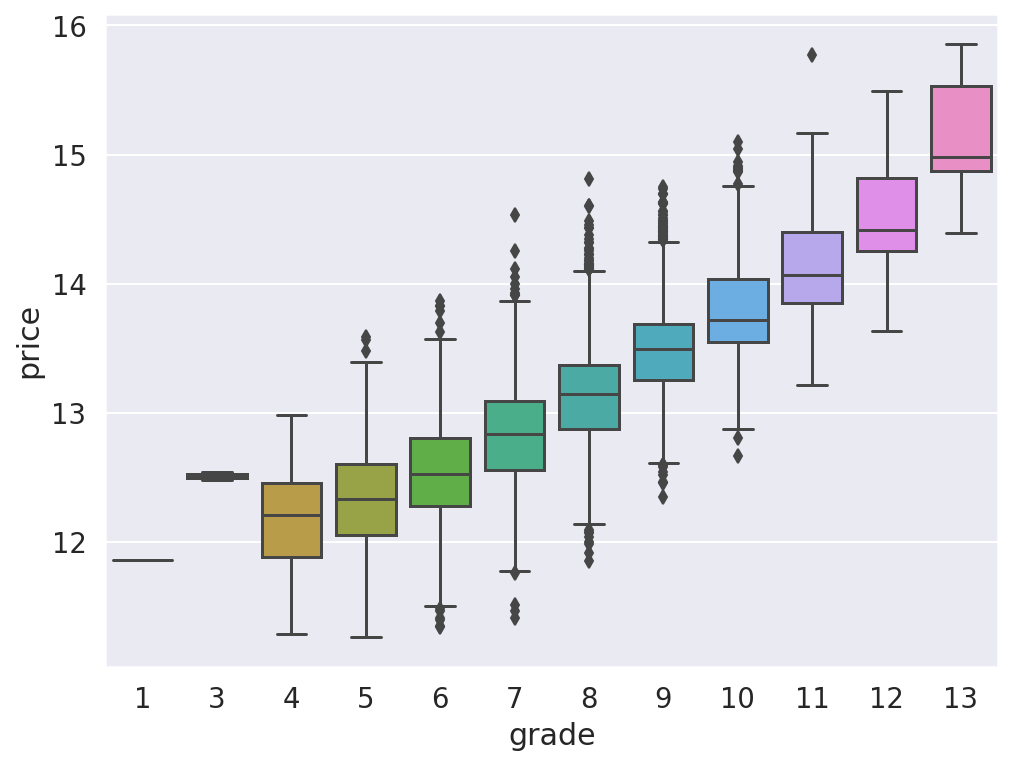

In [9]:
data = pd.concat([X_train['price'], X_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))

fig = sns.boxplot(x='grade', y="price", data=data)

grade를 보면 전반적으로 등급에따라 우상향하는 패턴을 보인다. 그런데 등급3의 박스가 등급 4보다 특이하게 올라가있다. 관련데이터를 삭제해주겠다.

In [10]:
X_train.loc[X_train['grade'] == 3]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [10]:
X_train = X_train.loc[X_train['id']!=4123]
X_train = X_train.loc[X_train['id']!=2302]

## sqft_living : 주거 공간의 평방 피트(면적)

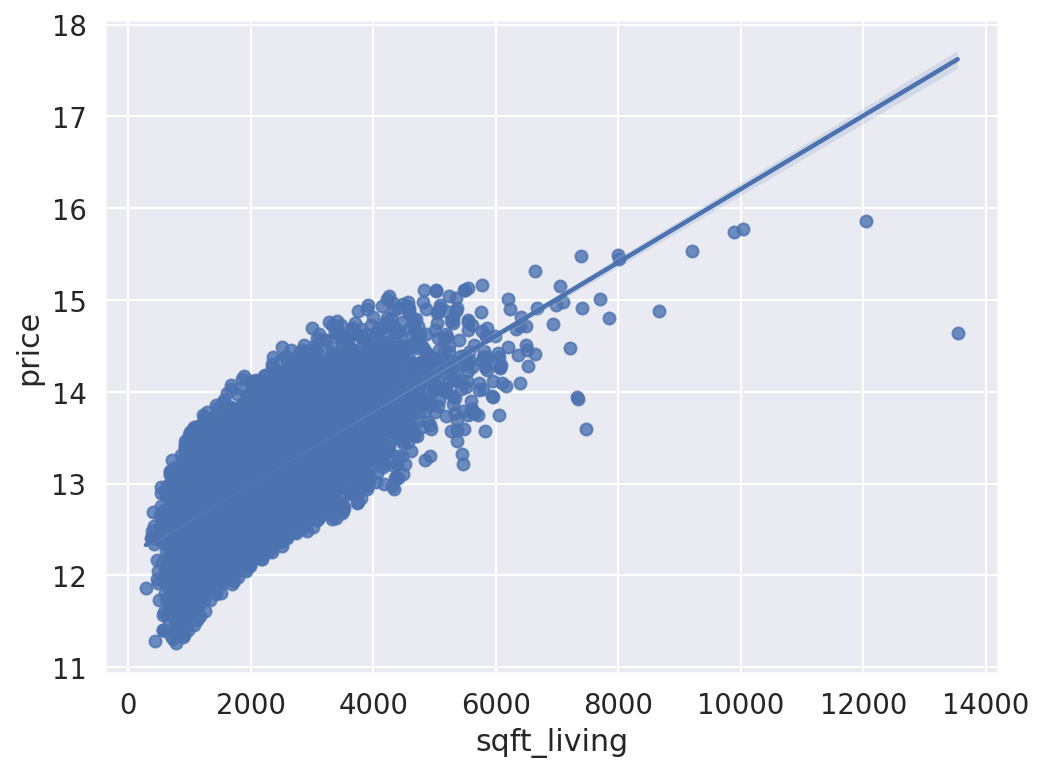

In [12]:
data = pd.concat([X_train['price'], X_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

sqft_living(주거 공간의 평방 피트)에따라 가격이 비례해서 올라가는반면 sqft_living이 14000 부근의 가격은 아주 낮아보인다. 이상치이므로 제거해주겠다,

In [11]:
X_train.loc[X_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [12]:
X_train = X_train.loc[X_train['id']!=8912]

## sqft_living15(2015년 기준 부지의 평방 피트)

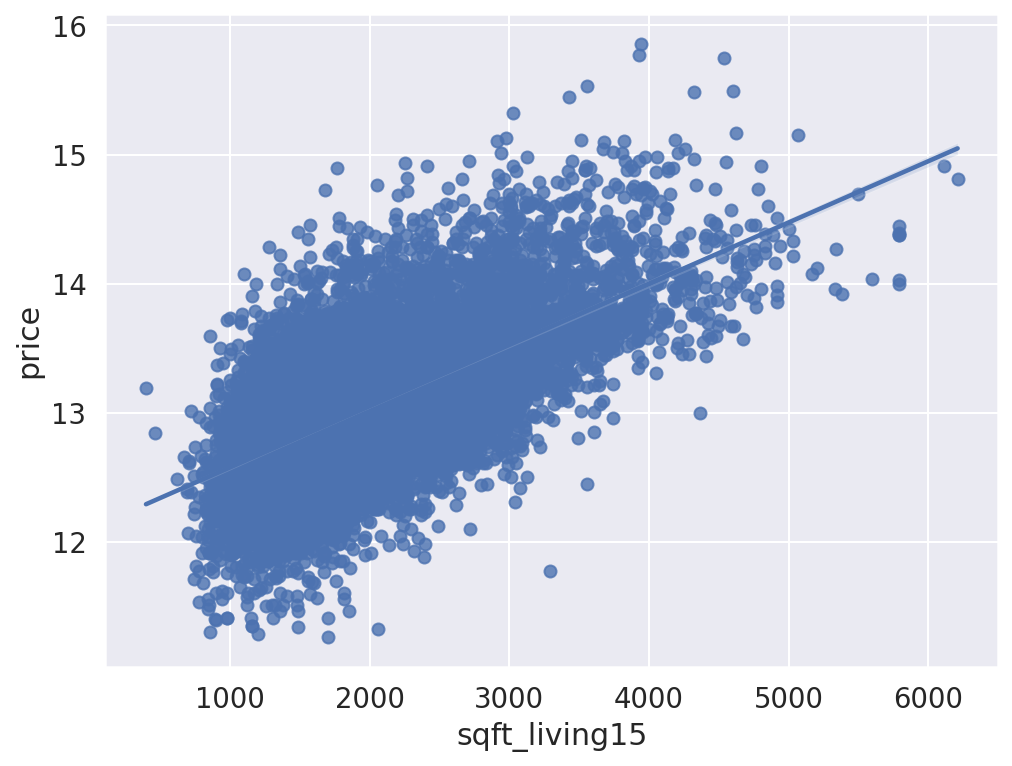

In [16]:
data = pd.concat([X_train['price'], X_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

sqft_living15의 데이터는 가격에 따라 대부분 비례하는 편으로보인다.

## sqft_above(지하실을 제외한 평방 피트)

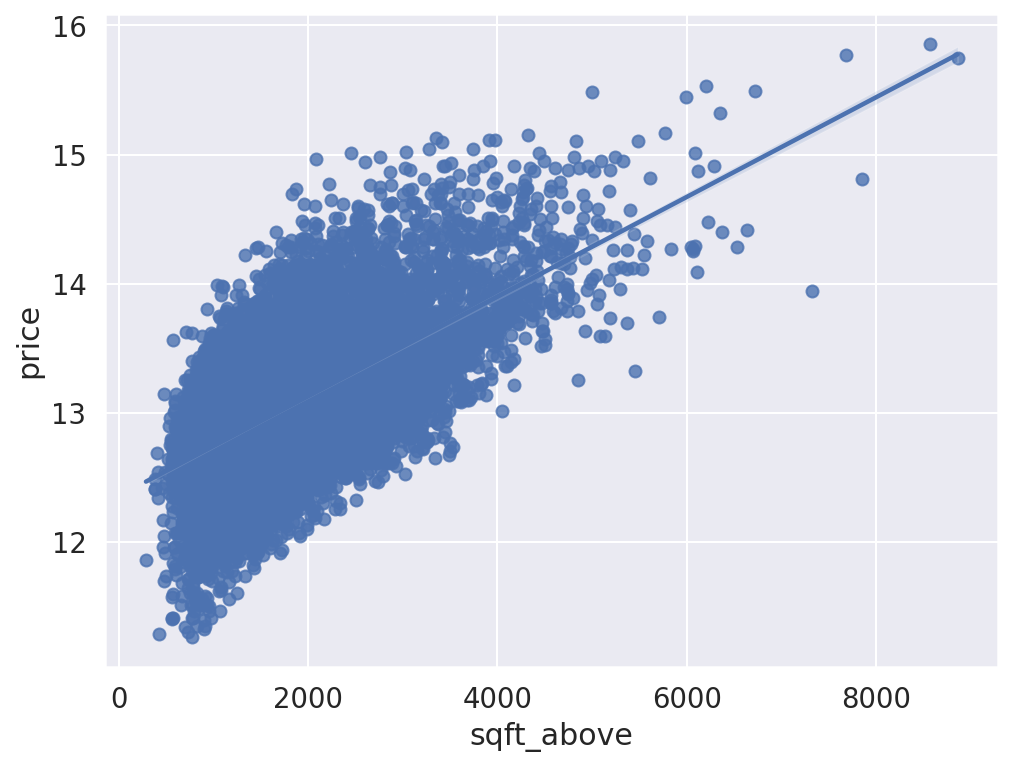

In [17]:
data = pd.concat([X_train['price'], X_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

sqft_living15의 데이터는 가격에 따라 대부분 비례하는 편으로보인다.

## bathrooms(화장실의 수)

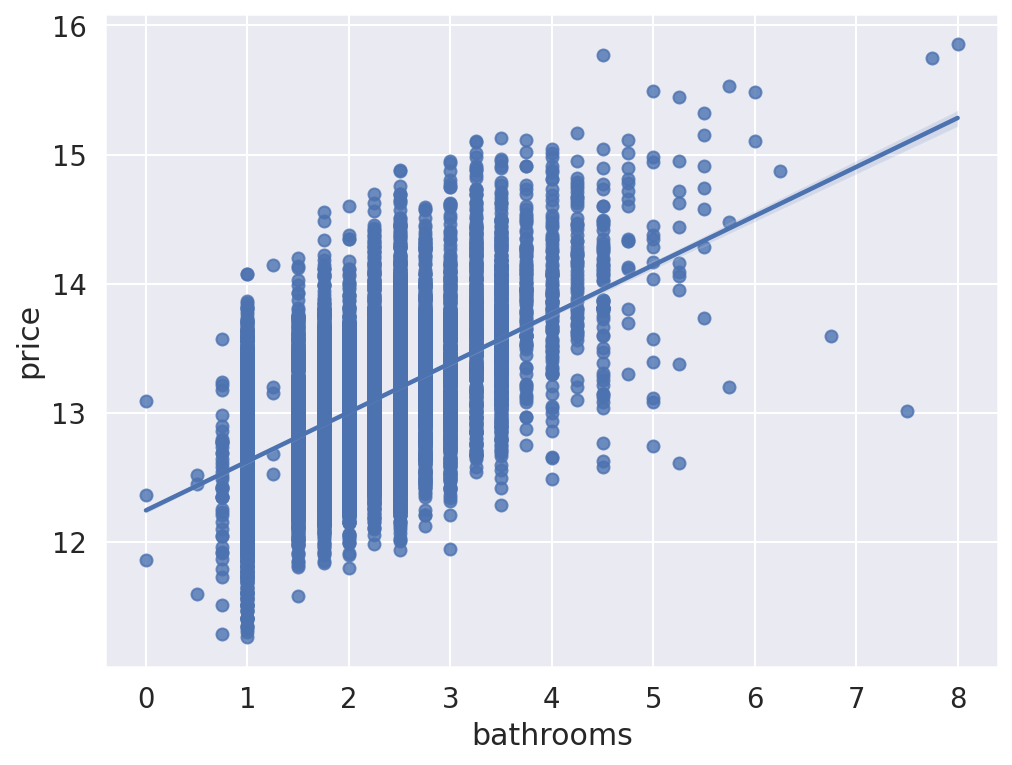

In [21]:
data = pd.concat([X_train['price'], X_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='bathrooms', y="price", data=data)

화장실의 수에 비례하여 가격이 우상향하는 분포를 보인다. 미국 화장실은 소수으로 셈하는 부분이 있어 소수점 부분에도 고르게 가격이 분포되는 특징이 보인다.


상관관계에 있는 데이터들을 알아보았다. 이제 Baseline모델에서 정규분포처리를 했던 나머지 컬럼에 로그함수를 취해주고, 필요없는 컬럼를 정리하고 타겟데이터를 분리해보겠다.


In [13]:
# 정규분포처리
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    X_train[c] = np.log1p(X_train[c].values)
    X_test[c] = np.log1p(X_test[c].values)

In [14]:
# 타겟데이터를 분리
y_train = X_train['price']
del X_train['price']

---
# 그리드서치(GridSearch)

이제 그리드서치를 통해 모델에 따라 최적의 하이퍼파라미터 조합을 찾아보자.

## my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) 함수

입력
 - 모델, train data, label data, 하이퍼파라미터 조합, 로그출력방식, CPU 코어 수

처리 순서
1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.


## GridSearchCV 함수 파라미터

- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [16]:
from sklearn.model_selection import GridSearchCV
random_state = 2020

In [17]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

## LGBMRegressor 모델의 그리드서치

In [18]:
param_grid = {
    'n_estimators': [500,1000], 
    'learning_rate': [0.1, 0.05], 
    'max_depth'    : [20,30]
}

model = LGBMRegressor(random_state=random_state)
res =my_GridSearch(model, X_train, y_train, param_grid, verbose=1)
res.head()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
5,0.05,20,1000,-0.026245,0.162002
7,0.05,30,1000,-0.026245,0.162002
4,0.05,20,500,-0.026276,0.162097
6,0.05,30,500,-0.026276,0.162097
0,0.10,20,500,-0.026896,0.163999


## XGBRegressor 모델의 그리드서치

In [ ]:
'''
param_grid = {
    'n_estimators': [500,1000], 
    'learning_rate': [0.1, 0.05], 
    'max_depth'    : [20,30]
}

model = XGBRegressor(random_state=random_state)
res=GridSearchScore(model, X_train, y_train, param_grid)
res.head()
'''

XGBRegressor 의 경우 LGBMRegressor와 동일한 파라미터 조합으로 그리드서치를 1시간넘게진행했지만 결과값을 얻을수 없었다.

## GradientBoostingRegressor 모델의 그리드서치

In [32]:
param_grid = {
    'n_estimators': [500,1000], 
    'learning_rate': [0.1, 0.05], 
    'max_depth'    : [20,30]
}

model = GradientBoostingRegressor(random_state=random_state)
res =my_GridSearch(model, X_train, y_train, param_grid, verbose=1)
res.head()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
4,0.05,20,500,-0.053347,0.230970
5,0.05,20,1000,-0.053347,0.230970
0,0.10,20,500,-0.053533,0.231371
1,0.10,20,1000,-0.053533,0.231371
6,0.05,30,500,-0.062001,0.249000


## RandomForestRegressor 모델의 그리드서치

In [33]:
param_grid = {
    'n_estimators': [500,1000],
    'max_features': [2,4,6],
    'max_depth'    : [20,30]
}

model = RandomForestRegressor(random_state=random_state)
res =my_GridSearch(model, X_train, y_train, param_grid, verbose=1)
res.head()

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,max_depth,max_features,n_estimators,score,RMSLE
5,20,6,1000,-0.031551,0.177625
11,30,6,1000,-0.031552,0.177630
10,30,6,500,-0.031585,0.177721
4,20,6,500,-0.031599,0.177762
9,30,4,1000,-0.032607,0.180574


---
그리드서치를 진행한 3가지 모델중 LGBMRegressor 모델이 RMSLE 값이 0.162002 로 가장 좋은 점수가 나왔다. 
하이퍼파라미터 learning_rate=0.05	max_depth=20	n_estimators=1000 일때 RMSLE 0.162002이다.
이 모델로 예측값을 만들어 보겠다. 
예측값을 만들어 submision파일은 만드는 함수를 구현해보자   	

In [19]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/project/exp05_Kaggle/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}.csv'.format(data_dir, model_name)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    

In [20]:
model = LGBMRegressor(max_depth=20, n_estimators=1000, learning_rate=0.05, random_state=random_state)
save_submission(model, X_train, y_train, X_test, 'LGBMRegressor')

/aiffel/aiffel/project/exp05_Kaggle/data/submission_LGBMRegressor.csv saved!


위 모델의 예측값으로 캐글에 제출시 Public score는 111879.56772 가 나왔다. 아직 루브릭에 못미치는 점수라서 좀더 개선을 해보겠다.

---

#  AveragingBlending

### Averaging이란?
Averaging은 각 모델이 계산해 낸 실숫값들을 평균 혹은 가중평균하여 사용하는 방법으로, 회귀 문제에서 사용된다.


XGBRegressor의 경우 기본값만드로도 하이퍼파라미터 튜닝보다 좋은 효과를 낸다고 하여 기본값 모델로 LGBMRegressor와 함께 블렌딩작업을해보겠다. GradientBoostingRegressor의 경우 함께 블랜딩했보았을때 CV 값이 적게나와 제외하였다.

In [21]:
xgboost = XGBRegressor(random_state=2019) 
lightgbm = LGBMRegressor(max_depth=20, n_estimators=1000, learning_rate=0.05, random_state=random_state)

models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]


In [22]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(X_train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=X_train.values, y=y_train, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

get_cv_score(models)

Model: XGBoost, CV score:0.8938
Model: LightGBM, CV score:0.9054


CV값이 0.8938, 0.9054으로 좋게나왔다. 이대로 AveragingBlending해도 좋을것 같다.

In [23]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

y_pred_blending = AveragingBlending(models, X_train, y_train, X_test)
y_pred_blending = np.expm1(y_pred_blending)
y_pred_blending

array([ 520024.01296029,  468033.27976313, 1417572.910343  , ...,
        482719.85172575,  328195.14634004,  449858.92354261])

In [24]:
def save_submission_without_train(model_name, y_pred):    
    data_dir = os.getenv('HOME')+'/aiffel/project/exp05_Kaggle/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = y_pred
 
    submission_csv_path = '{}/submission_{}.csv'.format(data_dir, model_name)
        
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))


In [25]:
save_submission_without_train('AveragingBlending', y_pred_blending)  

/aiffel/aiffel/project/exp05_Kaggle/data/submission_AveragingBlending.csv saved!


**Public socre값으로 108391.33857가 나왔다!!** 
![score](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp05/data/public_score2.png?raw=true)

---
# 정리

이번프로젝트를 통해 모델개선을 위한 여러방법을 익힌것 같다. 

- EDA분석을 통해 이상치 제거를 처음 해보았는데 제거한 이상치의 데이터가 훈련데이터셋에서 몇건 되지 않았음에도 점수에 향상에 많은 영향을 미친것같다. 


- 이번엔 로그변환을 통해 왜곡된 분포의 데이터도 바꾸어 보았다. 분포를 변경한것이 어떤영향을 미쳤는지는 아직 알지못하였다. 실제 레이블과 각컬럼간 상관관계를 알아볼때 로그함수로 정규분포로 바꾸어 히트맵을 출력했을때와 정규분포가 아닐때 상관관계는 그대로였다. 


- 회귀 에서 사용하는 앙상블 기법으로 에버리징(Averaging) 블랜딩을 적용해보았다. 확실히 개별모델보다 좋은 결과가 나와서 캐글대회에서 자주 사용되는 이유를 알것 같았다. 하지만 에버리징블랜딩으로 좋은 성과를 내기위해 개별모델자체적으로도 좋은 모델링이 되어야하기때문에 에버리징(Averaging) 블랜딩은 개별 모델의 성능이 뒷바침되어야 더 좋은 결과가 나올것이다. 실제로 3가지 모델을 블렌딩해보았을때 두모델은 우수한데비해 한모델의 CV점수가 좀 낮아서 블렌딩 결과가 좋지않았다.


- 최고의 조합을 찾는 그리드서치도 해보았다. 하지만 경험이 부족으로 그리드서치에 지정해주어야하는 하이퍼파라미터 범위를 임의로 지정해서 내가 찾은 결과가 최선인지 알수없었다. 다음엔 랜덤 서치를 시도해보는것도 좋을것 같다. 또한 LightGBM의 경우 그리드서치가 바로끝나는 반면에 다른모델의 경우 찾는데 오래걸려 처음엔 에러가 있는게 아닌지 삽질을 계속했는데 서치 시간이 모델에 따라 오래걸림수 있음을 알게되었다. 


---

# Reference
- [캐글코리아 경진대회](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)
- [캐글코리아 노트북](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks)
- [태디노트](https://teddylee777.github.io/scikit-learn/scikit-learn-ensemble)
- [LightGBM](https://injo.tistory.com/48)
- [하이퍼파라미터](http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/)
- 데이터 사이언스 스쿨 : [링크](https://datascienceschool.net/01%20python/04.03%20%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1.html?highlight=%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1)
- apply, lambda 활용 : [링크](https://data-newbie.tistory.com/207)
- 앙상블이란? : [링크](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.)
- 앙상블이 강력한 이유 : [링크](https://jamm-notnull.tistory.com/16)
- 회귀모델 성능지표 결정계수 : [링크](https://ltlkodae.tistory.com/19)